### Load libraries and external data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import colored
from colored import stylize
from data import dataloader
import datetime
import json
from neuralnet import nn
import numpy as np
import pandas as pd
import requests
from sklearn.metrics import confusion_matrix
import pixiedust_node #v≥0.2.5

Pixiedust database opened successfully


#### Load data from Firebase.
Requires [Firebase service account credentials](https://console.firebase.google.com/project/tingle-pilot-collected-data/settings/serviceaccounts/adminsdk) in JSON format saved in `./firebase-credentials`.

In [3]:
notepath = "data/notes.csv"
datapath = "data/pilot_data.csv"
corrections_path = "data/corrections.json"

if(
    os.path.exists(notepath) and
    os.path.exists(datapath)
):
    notes = pd.read_csv(notepath)
    pilot_data = pd.read_csv(datapath)
    print(stylize(
        "Data loaded from local file!",
        colored.fg(
            "green"
        )
    ))
else:
    pilot_data, notes = dataloader.load_from_firebase(
        notes=True,
        start=datetime.datetime(2018,3,6,9),
        stop=datetime.datetime(2018,3,7,18,32,47),
        combine=True,
        marked=False
    )
    pilot_data.to_csv(
        datapath,
        index=False
    )
    notes.to_csv(
        notepath,
        index=False
    )

if os.path.exists(corrections_path):
    with open("data/corrections.json", "r") as c:
        corrections = json.load(c)
else:
    corrections = {}

pixiedust_node 0.2.5 started. Cells starting '%%node' may contain Node.js code.
Data loaded from local file!


In [4]:
pilot_data = dataloader.index_participants(
    pilot_data,
    -4
)

In [5]:
pilot_data = pilot_data[pilot_data.participant != -2]

In [6]:
pilot_data = dataloader.correct_targets(
    pilot_data,
    'http://matter.childmind.org/js/tinglePilotAppScript.json'
)

In [7]:
pd.options.display.max_columns = 100
dataloader.count_ontarget_samples(pilot_data, True)

ontarget                                         \
participant                     -4   -3   -1    0   1   2   3   4   5   6    
step target                                                                  
1    food                         4    4   10    7   0   4  12   9   0  12   
2    food                         3    5    7   11   8   9  11  11  12  13   
3    food                         5    4    7    6   5  11  14  11   9  11   
4    thumb                       12    5    9    9  13  11  10  12   8  12   
5    thumb                       11    5   10    8   9  11  11  12  11  13   
6    thumb                       12    5   11    9  11  11  11  12  12  13   
7    nails                       11    6    8   10   9  10  16  10  13  12   
8    nails                       15    4   15   10  10  12  11  12  13  11   
9    nails                       13    8   12    6   9  15  11  11  13  12   
10   smoke                       14   19   12   11  10  13  11  15  11  14   
11   smoke                       10    4    8   11  10  14  10  13  11  10   
12   smoke                       15    5    9   11  11  14  13  13  11  13   
13   rotate-mouth               145  149  145  134  75  73  73  69  77  78   
14   nose                        11    7    7   11   8  10  10  10   8   8   
15   nose                        18    5    6   10  11  10   9  10  12  10   
16   nose                        20    5    8   10   9  13  10   3  11  11   
17   rotate-nose                147  150  141  140  73  69  74  75  77  76   
18   cheek                       13    4    7   10  10  10   9  12  10   9   
19   cheek                       16    6    6    9  10  12  10  12  11  12   
20   cheek                       19    5    9   10   9  11  12  12  12  11   
21   rotate-cheek               142  148  145  135  76  73  74  76  75  74   
22   eyebrow                     12    4    8   11   8  10   8  11  11  11   
23   eyebrow                     15    5    7    9  12  11   8  12  12  11   
24   eyebrow                     13    6    7    9   9  12   8  13  13  12   
25   rotate-eyebrow             145  146  146  138  71  67  75  76  75  75   
26   top-head                    11   12    7   10   5  10  10   9   9  11   
27   top-head                    14   11    7   11  10  12   9  10  12  11   
28   top-head                    14   11    8   11  11  11   9  10  12  13   
29   rotate-top-head            149  149  145  132  74  67  72  68  72  73   
30   back-head                   13    8    8   11   7  10   7  11  11  12   
31   back-head                   14    7    8   10  10  12  12  13  12  12   
32   back-head                   16   11    8    9  11  11  10  12  12  12   
33   rotate-back-head           144  149  143  126  67  75  72  72  72  76   
34   rotate-chin                146  149  146  129  72  75  64  77  73  76   
35   rotate-above-ear           150  148  142  126  74  75  51  73  72  75   
36   rotate-opposite-cheek      148  150  139  123  75  74  73  77  73  75   
37   paint-front-neck           146  146  140  131  74  66  64  71  71  76   
38   paint-back-neck            142  141  134  123  72  70  67  76  70  76   
39   paint-ear                  173  150  140  126  72  67  70  76  72  77   
40   paint-opposite-cheek       153  151  131  137  75  72  68  77  76  75   
41   paint-top-head             147  148  137  133  73  50  49  74  74  74   
42   paint-front-body           151   14   16   33  25  26  23  18  11  25   
43   offbody-ceiling             89    6    8    8  15  13  15   8  14  16   
44   offbody-floor               11   10   11    8  17  14  11  12  13  14   
45   offbody-+                   45   40   33   51  30  33  43  26  22  41   
46   offbody-X                   29   32   36   35  29  32  38  28  18  42   
47   offbody-spiral              44   38   58   51  47  39  63  39  23  64   

                                            
participant                 8   9   10  11  
step target                         

In [8]:
pilot_data = dataloader.correct_corrections(
    pilot_data,
    corrections
)

In [9]:
dataloader.count_ontarget_samples(pilot_data, True)

ontarget                                         \
participant                     -4   -3   -1    0   1   2   3   4   5   6    
step target                                                                  
1    food                         4    4   10    7   0   4  12   9   0  12   
2    food                         3    5    7   11   8   9  11  11  12  13   
3    food                         5    4    7    6   5  11  14  11   9  11   
4    thumb                       12    5    9    9  13  11  10  12   8  12   
5    thumb                       11    5   10    8   9  11  11  12  11  13   
6    thumb                       12    5   11    9  11  11  11  12  12  13   
7    nails                       11    6    8   10   9  10  16  10  13  12   
8    nails                       15    4   15   10  10  12  11  12  13  11   
9    nails                       13    8   12    6   9  15  11  11  13  12   
10   smoke                       14   19   12   11  10  13  11  15  11  14   
11   smoke                       10    4    8   11  10  14  10  13  11  10   
12   smoke                       15    5    9   11  11  14  13  13  11  13   
13   rotate-mouth               145  149  145  134  75  73  73  69  77  78   
14   nose                        11    7    7   11   8  10  10  10   8   8   
15   nose                        18    5    6   10  11  10   9  10  12  10   
16   nose                        20    5    8   10   9  13  10   3  11  11   
17   rotate-nose                147  150  141  140  73  69  74  75  77  76   
18   cheek                       13    4    7   10  10  10   9  12  10   9   
19   cheek                       16    6    6    9  10  12  10  12  11  12   
20   cheek                       19    5    9   10   9  11  12  12  12  11   
21   rotate-cheek               142  148  145  135  76  73  74  76  75  74   
22   eyebrow                     12    4    8   11   8  10   8  11  11  11   
23   eyebrow                     15    5    7    9  12  11   8  12  12  11   
24   eyebrow                     13    6    7    9   9  12   8  13  13  12   
25   rotate-eyebrow             145  146  146  138  71  67  75  76  75  75   
26   top-head                    11   12    7   10   5  10  10   9   9  11   
27   top-head                    14   11    7   11  10  12   9  10  12  11   
28   top-head                    14   11    8   11  11  11   9  10  12  13   
29   rotate-top-head            149  149  145  132  74  67  72  68  72  73   
30   back-head                   13    8    8   11   7  10   7  11  11  12   
31   back-head                   14    7    8   10  10  12  12  13  12  12   
32   back-head                   16   11    8    9  11  11  10  12  12  12   
33   rotate-back-head           144  149  143  126  67  75  72  72  72  76   
34   rotate-chin                146  149  146  129  72  75  64  77  73  76   
35   rotate-above-ear           150  148  142  126  74  75  51  73  72  75   
36   rotate-opposite-cheek      148  150  139  123  75  74  73  77  73  75   
37   paint-front-neck           146  146  140  131  74  66  64  71  71  76   
38   paint-back-neck            142  141  134  123  72  70  67  76  70  76   
39   paint-ear                  173  150  140  126  72  67  70  76  72  77   
40   paint-opposite-cheek       153  151  131  137  75  72  68  77  76  75   
41   paint-top-head             147  148  137  133  73  50  49  74  74  74   
42   paint-front-body           151   14   16   33  25  26  23  18  11  25   
43   offbody-ceiling             89    6    8    8  15  13  15   8  14  16   
44   offbody-floor               11   10   11    8  17  14  11  12  13  14   
45   offbody-+                   45   40   33   51  30  33  43  26  22  41   
46   offbody-X                   29   32   36   35  29  32  38  28  18  42   
47   offbody-spiral              44   38   58   51  47  39  63  39  23  64   

                                            
participant                 8   9   10  11  
step target                         

In [10]:
pilot_data = dataloader.update_too_few(
    pilot_data,
    "< 5"
)

In [11]:
dataloader.count_ontarget_samples(pilot_data, True)

ontarget                                         \
participant                     -4   -3   -1    0   1   2   3   4   5   6    
step target                                                                  
1    food                         5    6   10    7   8  15  12   9  18  12   
2    food                         3    5    7   11   8   9  11  11  12  13   
3    food                         5    6    7    6   5  11  14  11   9  11   
4    thumb                       12    5    9    9  13  11  10  12   8  12   
5    thumb                       11    5   10    8   9  11  11  12  11  13   
6    thumb                       12    5   11    9  11  11  11  12  12  13   
7    nails                       11    6    8   10   9  10  16  10  13  12   
8    nails                       15    7   15   10  10  12  11  12  13  11   
9    nails                       13    8   12    6   9  15  11  11  13  12   
10   smoke                       14   19   12   11  10  13  11  15  11  14   
11   smoke                       10    8    8   11  10  14  10  13  11  10   
12   smoke                       15    5    9   11  11  14  13  13  11  13   
13   rotate-mouth               145  149  145  134  75  73  73  69  77  78   
14   nose                        11    7    7   11   8  10  10  10   8   8   
15   nose                        18    5    6   10  11  10   9  10  12  10   
16   nose                        20    5    8   10   9  13  10   7  11  11   
17   rotate-nose                147  150  141  140  73  69  74  75  77  76   
18   cheek                       13    7    7   10  10  10   9  12  10   9   
19   cheek                       16    6    6    9  10  12  10  12  11  12   
20   cheek                       19    5    9   10   9  11  12  12  12  11   
21   rotate-cheek               142  148  145  135  76  73  74  76  75  74   
22   eyebrow                     12    7    8   11   8  10   8  11  11  11   
23   eyebrow                     15    5    7    9  12  11   8  12  12  11   
24   eyebrow                     13    6    7    9   9  12   8  13  13  12   
25   rotate-eyebrow             145  146  146  138  71  67  75  76  75  75   
26   top-head                    11   12    7   10   5  10  10   9   9  11   
27   top-head                    14   11    7   11  10  12   9  10  12  11   
28   top-head                    14   11    8   11  11  11   9  10  12  13   
29   rotate-top-head            149  149  145  132  74  67  72  68  72  73   
30   back-head                   13    8    8   11   7  10   7  11  11  12   
31   back-head                   14    7    8   10  10  12  12  13  12  12   
32   back-head                   16   11    8    9  11  11  10  12  12  12   
33   rotate-back-head           144  149  143  126  67  75  72  72  72  76   
34   rotate-chin                146  149  146  129  72  75  64  77  73  76   
35   rotate-above-ear           150  148  142  126  74  75  51  73  72  75   
36   rotate-opposite-cheek      148  150  139  123  75  74  73  77  73  75   
37   paint-front-neck           146  146  140  131  74  66  64  71  71  76   
38   paint-back-neck            142  141  134  123  72  70  67  76  70  76   
39   paint-ear                  173  150  140  126  72  67  70  76  72  77   
40   paint-opposite-cheek       153  151  131  137  75  72  68  77  76  75   
41   paint-top-head             147  148  137  133  73  50  49  74  74  74   
42   paint-front-body           151   14   16   33  25  26  23  18  11  25   
43   offbody-ceiling             89    6    8    8  15  13  15   8  14  16   
44   offbody-floor               11   10   11    8  17  14  11  12  13  14   
45   offbody-+                   45   40   33   51  30  33  43  26  22  41   
46   offbody-X                   29   32   36   35  29  32  38  28  18  42   
47   offbody-spiral              44   38   58   51  47  39  63  39  23  64   

                                            
participant                 8   9   10  11  
step target                         

#### Load [Synaptic](http://caza.la/synaptic/)
If "Error: Cannot find module 'synaptic'", create and run these two cells:

1. ```
cd neuralnet
```

2. ```sh
!npm init -y
!npm install -s synaptic
```

In [12]:
%%node
var lstm = require('../../tingle_pilot_study/neuralnet/lstm.js');

---
### See all targets and number of available samples

In [13]:
with open("neuralnet/targets.json", 'r') as fp:
    targets = json.load(fp)

In [14]:
pd.options.display.max_columns = 100 # unabridged
dataloader.count_ontarget_samples(pilot_data, True)

ontarget                                         \
participant                     -4   -3   -1    0   1   2   3   4   5   6    
step target                                                                  
1    food                         5    6   10    7   8  15  12   9  18  12   
2    food                         3    5    7   11   8   9  11  11  12  13   
3    food                         5    6    7    6   5  11  14  11   9  11   
4    thumb                       12    5    9    9  13  11  10  12   8  12   
5    thumb                       11    5   10    8   9  11  11  12  11  13   
6    thumb                       12    5   11    9  11  11  11  12  12  13   
7    nails                       11    6    8   10   9  10  16  10  13  12   
8    nails                       15    7   15   10  10  12  11  12  13  11   
9    nails                       13    8   12    6   9  15  11  11  13  12   
10   smoke                       14   19   12   11  10  13  11  15  11  14   
11   smoke                       10    8    8   11  10  14  10  13  11  10   
12   smoke                       15    5    9   11  11  14  13  13  11  13   
13   rotate-mouth               145  149  145  134  75  73  73  69  77  78   
14   nose                        11    7    7   11   8  10  10  10   8   8   
15   nose                        18    5    6   10  11  10   9  10  12  10   
16   nose                        20    5    8   10   9  13  10   7  11  11   
17   rotate-nose                147  150  141  140  73  69  74  75  77  76   
18   cheek                       13    7    7   10  10  10   9  12  10   9   
19   cheek                       16    6    6    9  10  12  10  12  11  12   
20   cheek                       19    5    9   10   9  11  12  12  12  11   
21   rotate-cheek               142  148  145  135  76  73  74  76  75  74   
22   eyebrow                     12    7    8   11   8  10   8  11  11  11   
23   eyebrow                     15    5    7    9  12  11   8  12  12  11   
24   eyebrow                     13    6    7    9   9  12   8  13  13  12   
25   rotate-eyebrow             145  146  146  138  71  67  75  76  75  75   
26   top-head                    11   12    7   10   5  10  10   9   9  11   
27   top-head                    14   11    7   11  10  12   9  10  12  11   
28   top-head                    14   11    8   11  11  11   9  10  12  13   
29   rotate-top-head            149  149  145  132  74  67  72  68  72  73   
30   back-head                   13    8    8   11   7  10   7  11  11  12   
31   back-head                   14    7    8   10  10  12  12  13  12  12   
32   back-head                   16   11    8    9  11  11  10  12  12  12   
33   rotate-back-head           144  149  143  126  67  75  72  72  72  76   
34   rotate-chin                146  149  146  129  72  75  64  77  73  76   
35   rotate-above-ear           150  148  142  126  74  75  51  73  72  75   
36   rotate-opposite-cheek      148  150  139  123  75  74  73  77  73  75   
37   paint-front-neck           146  146  140  131  74  66  64  71  71  76   
38   paint-back-neck            142  141  134  123  72  70  67  76  70  76   
39   paint-ear                  173  150  140  126  72  67  70  76  72  77   
40   paint-opposite-cheek       153  151  131  137  75  72  68  77  76  75   
41   paint-top-head             147  148  137  133  73  50  49  74  74  74   
42   paint-front-body           151   14   16   33  25  26  23  18  11  25   
43   offbody-ceiling             89    6    8    8  15  13  15   8  14  16   
44   offbody-floor               11   10   11    8  17  14  11  12  13  14   
45   offbody-+                   45   40   33   51  30  33  43  26  22  41   
46   offbody-X                   29   32   36   35  29  32  38  28  18  42   
47   offbody-spiral              44   38   58   51  47  39  63  39  23  64   

                                            
participant                 8   9   10  11  
step target                         

In [15]:
targets

{'onbody': [{'target': ['food', 'thumb', 'nails', 'smoke'],
   'train-ontarget': ['rotate-mouth'],
   'train-onbody-offtarget': {'paint': ['paint-back-neck',
     'paint-ear',
     'paint-front-body',
     'paint-opposite-cheek',
     'paint-top-head'],
    'rotate': ['rotate-above-ear',
     'rotate-back-head',
     'rotate-cheek',
     'rotate-eyebrow',
     'rotate-nose',
     'rotate-opposite-cheek',
     'rotate-top-head']}},
  {'target': ['nose'],
   'train-ontarget': ['rotate-nose'],
   'train-onbody-offtarget': {'paint': ['paint-back-neck',
     'paint-ear',
     'paint-front-body',
     'paint-front-neck',
     'paint-opposite-cheek',
     'paint-top-head'],
    'rotate': ['rotate-above-ear',
     'rotate-back-head',
     'rotate-cheek',
     'rotate-chin',
     'rotate-eyebrow',
     'rotate-mouth',
     'rotate-opposite-cheek',
     'rotate-top-head']}},
  {'target': ['cheek'],
   'train-ontarget': ['rotate-cheek'],
   'train-onbody-offtarget': {'paint': ['paint-back-neck',


---
### Extract training and testing data
Define targets of interest and corresponding offtargets

with open(
    'data/targets.json',
    'r'
) as fp:
    targets = json.load(
        fp
    )[0]

Set parameters for nn:

In [16]:
input_signals = [
    "distance",
    "thermopile1",
    "thermopile2",
    "thermopile3",
    "thermopile4"
]
n_samples = [300, 250, 200, 150, 100, 50]

In [17]:
six = pilot_data[pilot_data.participant == 6]

Get training inputs and outputs, inputs that should evaluate ~true and inputs that should evaluate ~false

In [18]:
train = {}
for participant in list(
    dataloader.count_ontarget_samples(
        six,
        True
    ).columns.levels[1]
):
    participant = int(participant)
    train[
        participant
    ] = {}
    for obt in targets['onbody']:
        for targ in ["nose"]:
            train[
                participant
            ][
                targ
            ] = {}
            train[
                participant
            ][
                targ
            ][
                "train"
            ] = {}
            for method in [
                "paint",
                "rotate"
            ]:
                train[
                    participant
                ][
                    targ
                ][
                    method
                ] = nn.define_trainer_data(
                    six[
                        six.participant==participant
                    ].dropna(
                        how="any",
                        subset=[
                            *input_signals,
                            "ontarget"
                        ]
                    ),
                    {
                        "target": obt[
                            "train-ontarget"
                        ],
                        "offtarget": obt[
                            "train-onbody-offtarget"
                        ][
                            method
                        ]
                    },
                    input_signals
                )
            train[
                participant
            ][
                targ
            ][
                'offbody'
            ] = nn.define_trainer_data(
                six[
                    six.participant==participant
                ].dropna(
                    how="any",
                    subset=[
                        *input_signals,
                        "ontarget"
                    ]
                ),
                {
                    "target": obt[
                        "train-ontarget"
                    ],
                    "offtarget": targets[
                        "train-offbody"
                    ]
                },
                input_signals
            )
            train[
                participant
            ][
                targ
            ][
                "test"
            ] = nn.define_trainer_data(
                    six[
                        six.participant==participant
                    ].dropna(
                        how="any",
                        subset=[
                            *input_signals,
                            "ontarget"
                        ]
                    ),
                    {
                        "target": obt[
                            "train-ontarget"
                        ],
                        "offtarget": []
                    },
                    input_signals
                )

In [20]:
six_unsplit = []
for a in train['6']['nose']:
    six_unsplit = [
        *six_unsplit,
        *train['6']['nose'][a]
    ]

Train / test split

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test = train_test_split(six_unsplit, test_size=0.25, random_state=42)

Preview all inputs and training outputs

**Note**: These data take some time to copy across environments. Give the notebook some time between running cells across Python and JavaScript.

---
### Train and test

In [24]:
%%node
var networks = {};
networks["nose"] = lstm.train_lstm([5,5,5,1], X_train, 0.06, 0.06, 3000);

iterations 10 error 0.33964640455558714 rate 0.06
iterations 15 error 0.2979419672558027 rate 0.06
iterations 20 error 0.23847356233320657 rate 0.06
iterations 25 error 0.20208506934241563 rate 0.06
iterations 30 error 0.18158144107125598 rate 0.06
iterations 35 error 0.16939302076434432 rate 0.06
iterations 40 error 0.1610273518449757 rate 0.06
iterations 45 error 0.15377702443110794 rate 0.06
iterations 50 error 0.14630021979038893 rate 0.06
iterations 55 error 0.13944226788695846 rate 0.06
iterations 60 error 0.1331782332229827 rate 0.06
iterations 65 error 0.12978998125398286 rate 0.06
iterations 70 error 0.1287103158762141 rate 0.06
iterations 75 error 0.13102211852155116 rate 0.06
iterations 80 error 0.12848575773846238 rate 0.06
iterations 85 error 0.1222726481718399 rate 0.06
iterations 90 error 0.11606489437005726 rate 0.06
iterations 95 error 0.11109979590424424 rate 0.06
iterations 100 error 0.11286795666166291 rate 0.06
iterations 105 error 0.09983680570595364 rate 0.06
ite

In [25]:
X_test

[{'input': [2.147164035497312,
   -0.823798574171227,
   0.3861292053993831,
   -0.06921335935564768,
   0.4976931447208374],
  'output': [0]},
 {'input': [-0.7362811729482716,
   1.0177890945495072,
   -0.5240271500246472,
   0.21911824711340278,
   -0.5641338188440351],
  'output': [0]},
 {'input': [-0.7362811729482716,
   -1.9287511754036666,
   -1.463543387881709,
   -0.1412962609729116,
   -1.0697657062558805],
  'output': [0]},
 {'input': [0.9990048574737309,
   0.9508222702323933,
   1.443084972988575,
   2.3095223940140253,
   1.584801702656308],
  'output': [0]},
 {'input': [-0.7362811729482716,
   1.3191398039765383,
   0.2099699108011817,
   -0.28546206420743425,
   -0.05850193143218971],
  'output': [0]},
 {'input': [-0.7362811729482716,
   -0.5559312769027528,
   -0.14234867839521698,
   -0.8260838263369058,
   -0.8927945456617375],
  'output': [0]},
 {'input': [1.3121391787528893,
   -0.32154739179284497,
   2.294521563546538,
   4.435967991723282,
   1.6353648913974896],

In [26]:
%%node
var test_outputs = {};
test_outputs["nose"] = {"true":[],"false":[]};
for(var iteration=0; iteration < X_test.length; iteration++){
  if (X_test[iteration]["output"][0] == 1) {
    test_outputs["nose"]["true"].push(networks["nose"].activate(X_test[iteration]["input"]));
  } else {
    test_outputs["nose"]["false"].push(networks["nose"].activate(X_test[iteration]["input"]));
  }
}

... ..... ..... ..... ..... ...


---
### See outputs

In [27]:
test_outputs["nose"]

{'true': [[0.9580903021688181],
  [0.9958848333783281],
  [0.9657510149351962],
  [0.9999920778115476],
  [0.9991459352553103],
  [0.9957312806538716],
  [0.9969251895742448],
  [0.9999980768759615],
  [0.9998953337337485],
  [0.9912510116646696],
  [0.9962310791706251],
  [0.11589389345179041],
  [0.9861489661897476],
  [0.6931151752128585],
  [0.9737167593731791],
  [0.9999585421705555],
  [0.12312437787042749],
  [0.9979043807824443],
  [0.9999999851470882],
  [0.9651863984056399],
  [0.9995876380061909],
  [0.9798243565138011],
  [0.8267288023096411],
  [0.6436756193752416],
  [0.979187186036221],
  [0.9999705478881925],
  [0.9359771438457825],
  [0.9998785334817482],
  [0.516996931014372],
  [0.9997443516208441],
  [0.9999830218863299],
  [0.9999219232607487],
  [0.9821661448324144],
  [0.3313695726468962],
  [0.9742586821937355],
  [0.7488708703724707],
  [0.973696321100805],
  [0.9999981658552165],
  [0.871033399980175],
  [0.9939053776211126],
  [0.9985521869103217],
  [0.99393

In [28]:
def calc_confusion(negative, positive):
    """
    Function to calculate a confusion matrix
    
    Parameters
    ----------
    negative: list of floats
        outputs of neural nets with true negative inputs
        
    positive: list of floats
        outputs of neural nets with true positive inputs
        
    Returns
    -------
    confusion: matrix of floats
        tn, fp, fn, tp
        see http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    """
    ytrue = [
        *[
            0 for output in negative
        ],
        *[
            1 for output in positive
        ]
    ]
    ypredicted = [
        *[
            int(round(o)) for o in negative
        ],
        *[
            int(round(o)) for o in positive
        ]
    ]
    return(confusion_matrix(ytrue, ypredicted))

If the training is adequate x ≈ 0 ∀ x in the following:

In [29]:
f = {target: [
        outputs for outputs in test_outputs[target]['false']
] for target in test_outputs}
f

{'nose': [[0.08506762635597627],
  [0.0014896125035033015],
  [1.7808286584378046e-06],
  [4.016431010524043e-09],
  [4.5487709431579536e-06],
  [2.5157594481182814e-05],
  [9.840825061933634e-06],
  [0.0009051350944830188],
  [3.1033694508760596e-09],
  [1.8101699766378253e-07],
  [0.8649870639807619],
  [0.004890492182354412],
  [0.08393607705153756],
  [0.0012699311582597315],
  [0.0006146195660750219],
  [0.00453574353066768],
  [0.9448270907316407],
  [9.313517679327313e-06],
  [8.516361906322235e-05],
  [0.00010691838208668901],
  [0.003015629612548251],
  [1.112465056724068e-06],
  [0.0087065912055276],
  [1.730624258340119e-08],
  [0.004910090242699443],
  [1.6831620886841014e-08],
  [0.020300227299421977],
  [0.0003563115443005148],
  [0.002830957137688773],
  [3.5177050806187305e-08],
  [0.01924381995745426],
  [0.0012091115434964255],
  [0.0011393748725926848],
  [0.00015908609897002091],
  [0.02424388017477577],
  [0.9183865447757246],
  [0.004924289735198914],
  [0.0301670

If the training is adequate x ≈ 1 ∀ x in the following:

In [30]:
t = {target: [
        outputs for outputs in test_outputs[target]['true']
] for target in test_outputs}
t

{'nose': [[0.9580903021688181],
  [0.9958848333783281],
  [0.9657510149351962],
  [0.9999920778115476],
  [0.9991459352553103],
  [0.9957312806538716],
  [0.9969251895742448],
  [0.9999980768759615],
  [0.9998953337337485],
  [0.9912510116646696],
  [0.9962310791706251],
  [0.11589389345179041],
  [0.9861489661897476],
  [0.6931151752128585],
  [0.9737167593731791],
  [0.9999585421705555],
  [0.12312437787042749],
  [0.9979043807824443],
  [0.9999999851470882],
  [0.9651863984056399],
  [0.9995876380061909],
  [0.9798243565138011],
  [0.8267288023096411],
  [0.6436756193752416],
  [0.979187186036221],
  [0.9999705478881925],
  [0.9359771438457825],
  [0.9998785334817482],
  [0.516996931014372],
  [0.9997443516208441],
  [0.9999830218863299],
  [0.9999219232607487],
  [0.9821661448324144],
  [0.3313695726468962],
  [0.9742586821937355],
  [0.7488708703724707],
  [0.973696321100805],
  [0.9999981658552165],
  [0.871033399980175],
  [0.9939053776211126],
  [0.9985521869103217],
  [0.99393

Finally, if training is adequate, f ≪ t:

In [31]:
f_mean = {
    target: np.mean(f[target]) for target in [
        t1 for t in targets['onbody'] for t1 in t['target']
    ] if target in f and len(f[target])
}
t_mean = {
    target: np.mean(t[target]) for target in [
        t1 for t in targets['onbody'] for t1 in t['target']
    ] if target in t and len(t[target])
}
for target in t_mean:
    print(target)
    print(
        "f = {0}\nt = {1}\n{0} ≪ {1} ?\n".format(
            str(f_mean[target]),
            str(t_mean[target])
        ) if f_mean[target] < t_mean[target] else "f = {0}\nt = {1}\n{2}".format(
            str(f_mean[target]),
            str(t_mean[target]),
            stylize(
                "Nope. f > t\n",
                colored.fg("red")
            )
        )
    )
for target in t_mean:
    print("{0}: f = {1:.4f} < t = {2:.4f}".format(
        target,
        f_mean[target],
        t_mean[target]
    ))

nose
f = 0.050414968838849265
t = 0.846607793897096
0.050414968838849265 ≪ 0.846607793897096 ?

nose: f = 0.0504 < t = 0.8466


In [32]:
calc_confusion(
    [
        output for o in test_outputs[
            "nose"
        ][
            "false"
        ] for output in o
    ],
    [
        output for o in test_outputs[
            "nose"
        ][
            "true"
        ] for output in o
    ]
)

array([[265,  10],
       [  9,  69]])

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
y_test = [
    *[0 for i in range(len(test_outputs["nose"]["false"]))],
    *[1 for i in range(len(test_outputs["nose"]["true"]))]
]
y_score = [
    *[
        round(output) for o in test_outputs[
            "nose"
        ][
            "false"
        ] for output in o
    ],
    *[
        round(output) for o in test_outputs[
            "nose"
        ][
            "true"
        ] for output in o
    ]
]
fpr = [0]
tpr = [0]
tp = 0
fp = 0
cumulative = []
roc_auc = []
total = max(
    len([y for y in y_score if y == 1]),
    len([y for y in y_test if y==1])
)
for i in range(len(y_test)):
    if y_score[i] == 1:
        if y_test[i] == 1:
            tp = tp + 1
            tpr.append(tp/total)
            fpr.append(fpr[-1])
        else:
            fp = fp + 1
            fpr.append(fp/total)
            tpr.append(tpr[-1])
        cumulative.append((tp + fp)/total)
for r in [fpr, tpr]:
    if r[-1] < 1:
        r.append(1)

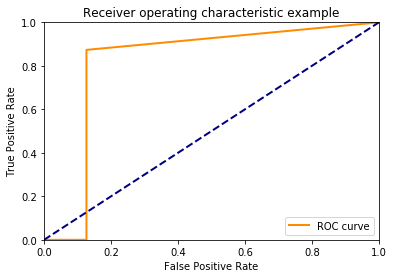

In [159]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

0.8181381188912034